In [4]:
import numpy as np
from scipy.stats import expon
from scipy.stats import uniform
import matplotlib.pyplot as plt

The procedure is as follows:

1) Using hazard function $\lambda(t) = 2t + 3$, compute the CDF of the distribution from which we can sample from using an inverse transform method. In this case, the CDF $\Lambda(t) = \int_0^t \lambda(t) = t^2 + 3t$, and the inverse of this is $\frac{-3 + \sqrt{9 + 4t}}{2}$

2) Generate uniform random variables $U(0,1)$ to serve as probabilities

3) Map uniform RVs (probabilities) to the inverse of the cumulative hazard function to generate RVs via $\frac{-3 + \sqrt{9 - 4log(1-U)}}{2}$

In [179]:
def f(t):
    return (-3 + np.sqrt(9 + 4*-np.log(1-t)))/2

In [185]:
r = uniform.rvs(size=1000)

In [186]:
hazard = f(r)

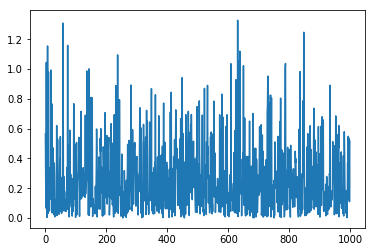

In [187]:
plt.plot(hazard)

(array([ 2.80216981,  1.8681132 ,  1.19770161,  0.69300974,  0.42183201,
         0.27871044,  0.12052343,  0.09792529,  0.03013086,  0.02259814]),
 array([  6.01411188e-04,   1.33355679e-01,   2.66109946e-01,
          3.98864214e-01,   5.31618481e-01,   6.64372749e-01,
          7.97127016e-01,   9.29881284e-01,   1.06263555e+00,
          1.19538982e+00,   1.32814409e+00]),
 <a list of 10 Patch objects>)

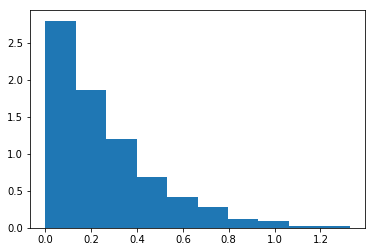

In [188]:
plt.hist(hazard, density=1)

a)

We need to select $a$ such that $\int_x^{\infty}5x\ e^{-x^2/2} I(x \geq \sqrt{log(a)})=1$

or 

$\int_{\sqrt{log(a)}}^{\infty}5x\ e^{-x^2/2} = 1$

$0 - 5 e^{-\sqrt{log(a)}^2/2} = 1$

$e^{-log(a)/2} = \frac{1}{5}$

$\frac{-log(a)}{2} = log(\frac{1}{5})$

$-log(a) = 2log(\frac{1}{5})$

$-log(a) = - log(5^2)$

$a = 25$

In [83]:
from scipy.integrate import quad

In [227]:
def f(a):
    return np.sqrt(np.log(a))

def integrand(x):
    return 5*x*(np.exp(1)**((-x**2)/2))

quad(integrand,f(25),np.inf)[0]

1.0

b)

Inverse Transform:

1) Generate Uniform RV U(0,1)

2) Use inverse of our function above, $F^{-1}(Y) = \sqrt{log(\frac{-5}{U-1})*2}$ to generate RVs

b)

Acceptance Rejection:

This is simple because our function $g(x)$ is really just a Rayleigh, with $f(x)$ being a multiple of $c = 5$ and $g(x)$, thus our acceptance rejection algorithm is as follows:

1) generate $Y$ with PDF $g(Y) = x\ e^{-x^2/2}$

2) generate $U$

3) while $U > \frac{f(Y)}{cg(Y)}$

    3a) generate Y
    3b) generate U

4) set X = Y

c)

Inverse transform is obviously much faster! This might be because I'm using vectorized computation in python, but it's more likely just due to the nature of acceptance rejection: i.e., there will be RVs generated that will not fit in the proposal density, and will therefore be rejected! Any rejection is a waste considering that none of the computations in inverse transform are rejected

In [337]:
import timeit
from scipy.stats import rayleigh

Mean:  2.2162836797
Variance:  0.132170189581
Time Elapsed:  0.0009097440051846206


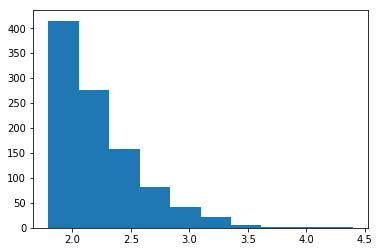

In [335]:
#c

#inverse transform

start = timeit.timeit()

u = uniform.rvs(size=1000)
inv = np.sqrt(2*np.log(-5/(u-1)))
print('Mean: ',np.mean(inv))
print('Variance: ',np.var(inv))

end = timeit.timeit()

plt.hist(inv)
print('Time Elapsed: ',start - end)

In [358]:
#c

#acceptance rejection

def acc_rej(n):
    start = timeit.timeit()
    X = np.zeros(n)
    i = 0
    while i < n:
        u = uniform.rvs(size=1)
        Y = rayleigh.rvs(size=1)
        if Y > np.sqrt(np.log(25)):
            g = 5*Y*np.exp((-Y)**2/2)*u
            f = 5*Y*np.exp((-Y)**2/2)
            if f > g:
                X[i] = Y
                i += 1
    end = timeit.timeit()
    time = (start - end)
    return X, time

Mean:  2.25752695566
Variance:  0.163172679983
Time Elapsed:  0.0034841509768739343


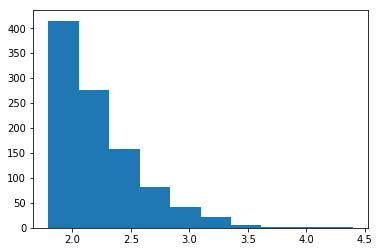

In [364]:
blop, time = acc_rej(1000)

plt.hist(inv)
print('Mean: ', np.mean(blop))
print('Variance: ', np.var(blop))
print('Time Elapsed: ',time)

The results on this are interesting because we can see that $T_{1,0,0}$ and $T_{1,1,0}$ converge to the same mean and variance. I assume this is because we're modeling an IID sequence of bernoullis where these two are basically the same in that we're modeling (success, fail, fail) and (success, success, fail) both with the same probability of success $p = 0.5$. 

The numbers produced below check out with what we would expect our expectation $E[T]$

In [312]:
print('Expectation of T000: ',(.5**-3-1)/(.5))
print('Expectation of T100: ',(.5**-2)/(.5))
print('Expectation of T110: ',(.5**-2)/(.5))

Expectation of T000:  14.0
Expectation of T100:  8.0
Expectation of T110:  8.0


In [111]:
from scipy.stats import bernoulli

In [158]:
def simulator(n):
    t0, t1, t2 = np.zeros(n), np.zeros(n), np.zeros(n)
    for i in range(n):
        r = bernoulli.rvs(.5, size=1000)
        for j in range(len(r)):
            if list(r[j:j+3]) == [0,0,0]:
                t0[i] = j + 3
                break
        for j in range(len(r)):
            if list(r[j:j+3]) == [1,0,0]:
                t1[i] = j + 3
                break
        for j in range(len(r)):
            if list(r[j:j+3]) == [1,1,0]:
                t2[i] = j + 3
                break
    print('Means: \n')
    print('T000: ', np.mean(t0))
    print('T100: ', np.mean(t1))
    print('T110: ', np.mean(t2),'\n')
    print('Variances: \n')
    print('T000: ', np.var(t0))
    print('T100: ', np.var(t1))
    print('T110: ', np.var(t2))

In [165]:
simulator(100)

Means: 

T000:  14.75
T100:  7.82
T110:  8.14 

Variances: 

T000:  133.5875
T100:  17.3076
T110:  23.5804


In [166]:
simulator(1000)

Means: 

T000:  14.037
T100:  8.312
T110:  8.101 

Variances: 

T000:  131.259631
T100:  27.528656
T110:  23.916799


In [167]:
simulator(10000)

Means: 

T000:  14.0108
T100:  7.9893
T110:  7.9923 

Variances: 

T000:  143.64928336
T100:  23.74598551
T110:  23.72164071


In [162]:
simulator(100000)

Means: 

T000:  13.95958
T100:  7.98956
T110:  8.00628 

Variances: 

T000:  141.506046224
T100:  23.8529910064
T110:  24.3521605616


In [163]:
simulator(1000000)

Means: 

T000:  14.004606
T100:  8.00121
T110:  7.995476 

Variances: 

T000:  142.027150785
T100:  24.0230725359
T110:  24.0016955334


In [323]:
from scipy.stats import geom

Given $P(X = j) = \frac{1}{2}(p_1 + p_2)$ we can say that this is a mixture of geometric distributions and thus simplify to $p_1 \sim Geom(1/2)$ and $p_2 \sim Geom(1/3)$, and we can generate geometric RVs via the composition method


An easier way to code it is to just generate $p_1 \sim Geom(1/2)$ and $p_2 \sim Geom(1/3)$


1) Generate two bernoulli RVs: $U_1$ and $U_2$

2) 

If $U_1 < \frac{1}{2}:\ Y \sim Geom(1/2)$

If $U_1 > \frac{1}{2}:\ Y \sim Geom(1/3)$

3) Set $X = Y_j$

In [324]:
def new_p5(n):
    X = np.zeros(n)
    for i in range(n):
        u = bernoulli.rvs(1/2, size=1)
        if u[0] < 1/2:
            Y = geom.rvs(1/2, size=1)
        else:
            Y = geom.rvs(1/3, size=1)
        X[i] = Y
    return X

Mean:  2.522
Variance:  4.175516


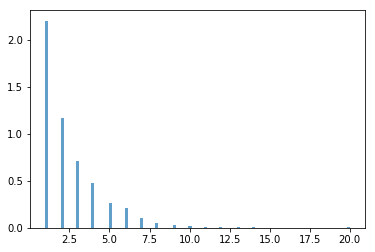

In [325]:
blop = new_p5(1000)
plt.hist(blop, 100, density=100, alpha=0.7)
print('Mean: ',np.mean(blop))
print('Variance: ',np.var(blop))